# Geoprocessing
## Lesson Goals

We'll walk through some typical topological operations (spatial subsetting, spatial joins, dissolve) with vector data using using `GeoPandas` - followed by a couple 'real world' spatial tasks.  We'll also incorporate a bit of raster processing such as map algebra, cropping, and zonal statistics.

## Spatial Subsetting
We'll work with gages data from the previous section, and incorporate NHD streamlines, basins and HUC12 data using services to demonstrate spatial subsetting. We'll demonstrate using the `dataRetrieval` package to query the [Network Linked Data Index](https://labs.waterdata.usgs.gov/about-nldi/index.html) based on the [NLDI Interface] `dataRetrieval` package article by Mike. 

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

infile = "Gages_flow_flowdata.csv"
Use_Cols = ["COMID", "REACHCODE", "STATE", "LON_NHD", "LAT_NHD", "DA_SQ_MILE", "AVE"]
df = pd.read_csv(infile, usecols=Use_Cols, keep_default_na=False, na_values=[""])
df.columns

Index(['COMID', 'REACHCODE', 'STATE', 'DA_SQ_MILE', 'LON_NHD', 'LAT_NHD',
       'AVE'],
      dtype='object')

And again we'll promote our `pandas` dataframe to a `GeoPandas` `GeoDataFrame` as we did in the last section.  Here also use the `explore` method in `GeoPandas` to quickly generate an interactive map of our data, rather than a simple plot with `matplotlib`.

In [3]:
import geopandas as gpd
import numpy as np

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LON_NHD, df.LAT_NHD, crs="EPSG:4269"))
gdf[["AVE"]] = gdf[["AVE"]].apply(np.log10)
gdf.loc[gdf["AVE"] < 0, "AVE"] = np.nan
gdf.explore("AVE", cmap="Blues")

Here we emulate how we read an ESRI file geodabase file in R with `sf`.  Note that we can specify layer by name or index in `geopandas` (though in this case there is only one layer).

<AxesSubplot:>

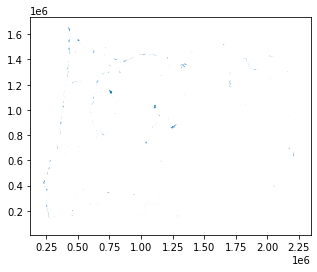

In [4]:
parks = gpd.read_file("OregonStateParks_20181010.gdb", driver="FileGDB", layer="LO_PARKS")
# parks = gpd.read_file('OregonStateParks_20181010.gdb',
#                     driver='FileGDB', layer=0)
parks.plot()

#### Read in geopackage file with geopandas

<AxesSubplot:>

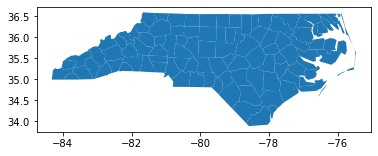

In [5]:
import fiona

fiona.listlayers("nc.gpkg")
# parks = gpd.read_file('GitProjects/AWRA2022GeoWorkshop/Workbooks/R/Session2/nc.gpkg',
#                     driver='GPKG', layer='nc')
nc = gpd.read_file("nc.gpkg", driver="GPKG", layer=0)
nc.plot()

### Open spatial data sources

There's a wealth of open spatial data accessible online now via static URLs or APIs - just a few examples include [Data.gov](https://catalog.data.gov/dataset?metadata_type=geospatial), NASA [SECAC Portal](http://sedac.ciesin.columbia.edu/), [Natural Earth](http://www.naturalearthdata.com/), [UNEP GEOdata](http://geodata.grid.unep.ch/), and countless others listed here at [Free GIS Data](https://freegisdata.rtwilson.com/)

Below is an example similar to what we did in R using `naturalearth` data - note that geopandas only includes a couple datasets from naturalearth - we show using the `naturalearth_lowres` data - to get other `naturalearth` data you need to read in from a zip file directly which we show as well.

In [6]:
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

<AxesSubplot:>

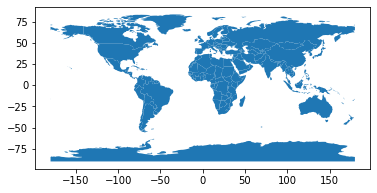

In [7]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world.plot()

Here we read in US states directly from a source of [compiled geojson data for the US](https://eric.clst.org/tech/usgeojson/)

<AxesSubplot:>

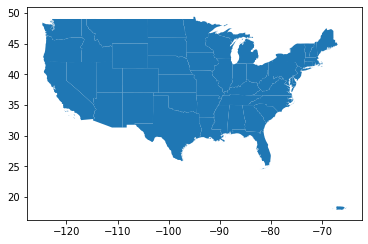

In [8]:
states = gpd.read_file(
    "https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json"
)
states = states[~states["NAME"].isin(["Hawaii", "Alaska"])]
states.plot()

In [9]:
states.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US23,23,Maine,,30842.923,"MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ..."
1,0400000US25,25,Massachusetts,,7800.058,"MULTIPOLYGON (((-70.83204 41.60650, -70.82373 ..."
2,0400000US26,26,Michigan,,56538.901,"MULTIPOLYGON (((-88.68443 48.11579, -88.67563 ..."
3,0400000US30,30,Montana,,145545.801,"POLYGON ((-104.05770 44.99743, -104.25015 44.9..."
4,0400000US32,32,Nevada,,109781.180,"POLYGON ((-114.05060 37.00040, -114.04999 36.9..."


#### Reading in subsets of vector data
Just read in just Oregon using a row filter - this is a cheat! I looked up the row index for Oregon in the full set above - I don't know how to do a read-in filter using an attribute query with geopandas - does anyone?

<AxesSubplot:>

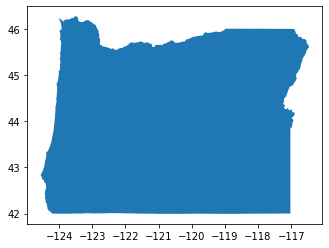

In [10]:
OR = gdf = gpd.read_file(
    "https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json",
    rows=slice(45, 46),
)
OR.plot()

We can also apply a geometry or bounding box fliter as another type of mask on read-in

<AxesSubplot:>

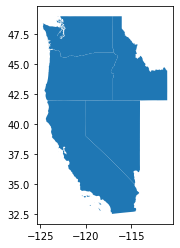

In [11]:
OR_Plus = gpd.read_file(
    "https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json",
    mask=states[states.NAME == "Oregon"],
)
OR_Plus.plot()

Read [the docs](https://geopandas.org/en/stable/docs/user_guide/io.html) - the mask above is actually using a spatial filter and reading in data the *intersects* with our filter criteria (i.e. Oregon).  Using a bounding box.

In [12]:
OR.total_bounds

array([-124.565973,   41.991794, -116.463504,   46.271004])

We can truncate that bounding box and pass it in, or use it as is in the bbox argument to read_file - not that the bbox argument requires a tuple, and the `total_bounds` method returns an array - we need to convert the array to a tuple to use

<AxesSubplot:>

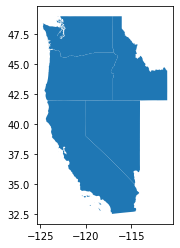

In [13]:
OR_bbox = tuple(OR.total_bounds)
OR = gpd.read_file(
    "https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json",
    bbox=OR_bbox,
)
OR.plot()

In [14]:
bbox = (-122.0, 42.5, -118.0, 45.0)

<AxesSubplot:>

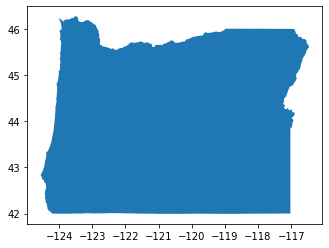

In [15]:
OR = gpd.read_file(
    "https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json",
    bbox=bbox,
)
OR.plot()

#### Read in OpenStreetMap data
`osmnx` is a Python package for working with OpenStreetMap data in Python as either Geopandas Geodataframes or `networkx` network objects - here we do a simple retrieval of all lines designated as 'bike' from OSM for Corvallis as a network object.

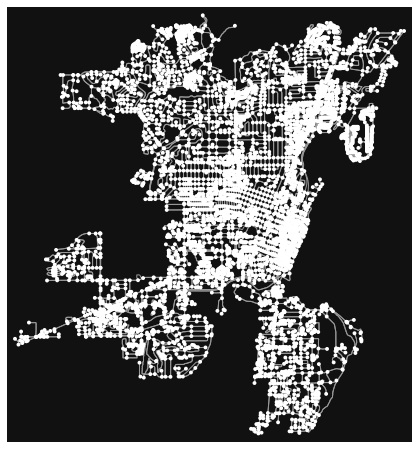

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [16]:
import osmnx as ox

place = [
    "Corvallis, Oregon, USA",
]
G = ox.graph_from_place(place, network_type="bike")
ox.plot_graph(G)

We can retrieve restarants for Corvallis as well and get some information

In [17]:
# Retrieve restaurants
tags = {"amenity": "restaurant"}
restaurants = ox.geometries_from_place(place, tags)
# How many restaurants do we have?
len(restaurants)

70

See what the `geodataframe` looks like

In [18]:
restaurants.columns
# or
# restaurants.info()

Index(['amenity', 'cuisine', 'name', 'geometry', 'addr:city',
       'addr:housenumber', 'addr:postcode', 'addr:street', 'wheelchair',
       'opening_hours', 'addr:state', 'contact:phone', 'contact:website',
       'diet:vegan', 'diet:vegetarian', 'operator', 'phone', 'email',
       'website', 'fax', 'brand', 'brand:wikidata', 'brand:wikipedia',
       'capacity', 'takeaway', 'delivery', 'addr:unit', 'nodes', 'building',
       'smoking', 'official_name', 'branch', 'source', 'outdoor_seating'],
      dtype='object')

Convert our bike path network to a geodtaframe and plot with restaurants

/Users/taher/.local/apps/mambaforge/envs/awra2022/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/taher/.local/apps/mambaforge/envs/awra2022/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/taher/.local/apps/mambaforge/envs/awra2022/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/taher/.local/apps/mambaforge/envs/awra2022/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version i

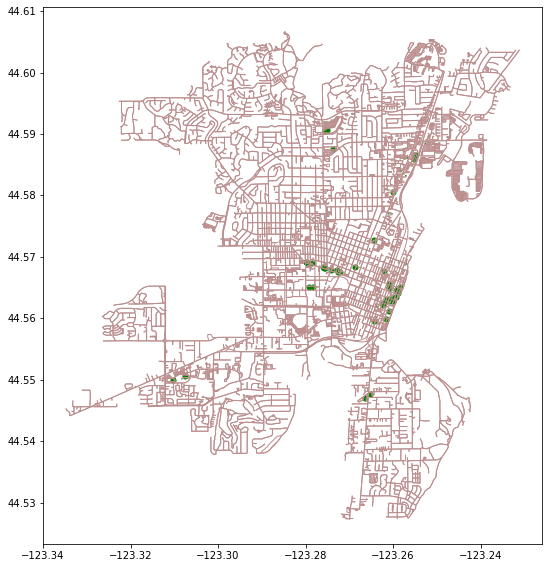

In [19]:
import matplotlib.pyplot as plt

nodes, paths = ox.graph_to_gdfs(
    G
)  # this method expects unpacking to a tuple so we need to two obects on left
# paths.head()
fig, ax = plt.subplots(figsize=(12, 8))

# Plot restaurants
restaurants.plot(ax=ax, color="green", markersize=26)

# Plot street edges
paths.plot(ax=ax, linewidth=1, edgecolor="#BC8F8F")

plt.tight_layout()

#### Exercise
Based on examples of reading in different datasets and subsetting, try to find a dataset online to read in, or try a different subset operation on example datasets so far, or both.

### Raster Data
For reading and writing raster data in Python we'll use rioxarray in this session, which is based on rasterio package for working with rasters and xarray for working with multi-dimensional arrays - rioxarray basically extends xarray with the rio accessor. There are a lot of ways to work with raster data in Python and we could spend a whole day on it, but this will get us working quickly with raster structures.

We can open datasets using several open methods with rioxarray described [in the docs](https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html) - we will use the `open_rasterio` method.

Here we'll also avoid downloading and using local data by taking advantage of [Cloud-optimized Geotiffs (COGs)](http://www.cogeo.org/) - here we're getting Landsat data from Google Cloud Storage as described in this [great tutorial](https://geohackweek.github.io/raster/04-workingwithrasters/)

In [20]:
import rioxarray
import xarray

filepath = "https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF"
rds = rioxarray.open_rasterio(filepath)
rds

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 88 from PyObject


<xarray.DataArray (band: 1, y: 7951, x: 7821)>
[62184771 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.043e+05 2.043e+05 ... 4.389e+05 4.389e+05
  * y            (y) float64 4.268e+06 4.268e+06 4.268e+06 ... 4.03e+06 4.03e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

By default, `xarray` gives us an html representation of the data - this includes information on the dimensions of the array, the list of coordinates, and a list of attributes.  `xarray` make it easy to discover information describing our raster:

In [21]:
rds.spatial_ref

<xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int64 0
Attributes:
    crs_wkt:                           PROJCS["WGS 84 / UTM zone 11N",GEOGCS[...
    semi_major_axis:                   6378137.0
    semi_minor_axis:                   6356752.314245179
    inverse_flattening:                298.257223563
    reference_ellipsoid_name:          WGS 84
    longitude_of_prime_meridian:       0.0
    prime_meridian_name:               Greenwich
    geographic_crs_name:               WGS 84
    horizontal_datum_name:             World Geodetic System 1984
    projected_crs_name:                WGS 84 / UTM zone 11N
    grid_mapping_name:                 transverse_mercator
    latitude_of_projection_origin:     0.0
    longitude_of_central_meridian:     -117.0
    false_easting:                     500000.0
    false_northing:                    0.0
    scale_factor_at_central_meridian:  0.9996
    spatial_ref:                       PROJCS["WGS 84 / UTM zone 11N",GEOGCS[...
    GeoTransform:                      204285.0 30.0 0.0 4268115.0 0.0 -30.0

...Or more succinct coordinate reference system (CRS) information - EPSG codes are a concise way of passing along CRS information - [spatialreference.org](spatialreference.org) is where I typically look up this information

In [22]:
rds.rio.crs

CRS.from_epsg(32611)

In [23]:
rds.dims

('band', 'y', 'x')

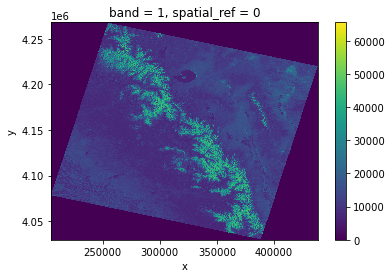

In [24]:
rds.plot()

### Convert flat files to spatial
We often have flat files, locally on our machine or accessed elsewhere, that have coordinate information which we would like to make spatial. 

In the steps below, we 

  1. read in a .csv file of USGS gages in the PNW that have coordinate columns using `read_csv` from `pandas`<br>
      a. Note that we select only certain columns to read in, and that we have to specify '' as NA values - otherwise we get an error from `pandas`<br>
  2. Use `GeoDataFrame` function in `GeoPandas` to convert the data frame to an `GeoDataFRame` - a `pandas` dataframe with a geometry list-column, analagous to our spatial data frame in R<br>
      a. passing the coordinate columns to the gpd.points_from_xy function<br>
      b. specifying a coordinate reference system (CRS)<br>
  4. Plotting our gages as spatial features with `ggplot2` using `geom_sf`.
  
 The [GeoPandas documentation on creating a GeoDataFrame from coordinates](https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html) describes the details.

In [25]:
import pandas as pd

infile = "Gages_flow_flowdata.csv"
Use_Cols = ["COMID", "REACHCODE", "STATE", "LON_NHD", "LAT_NHD", "DA_SQ_MILE", "AVE"]
df = pd.read_csv(infile, usecols=Use_Cols, keep_default_na=False, na_values=[""])
list(df)

['COMID', 'REACHCODE', 'STATE', 'DA_SQ_MILE', 'LON_NHD', 'LAT_NHD', 'AVE']

In [26]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LON_NHD, df.LAT_NHD, crs="EPSG:4269"))

print(gdf.head())

   COMID       REACHCODE STATE  DA_SQ_MILE     LON_NHD    LAT_NHD       AVE  \
0      0  17100308000014    OR      2459.0 -123.318206  42.429592  3402.544   
1      0  17100307000112    OR        52.0 -122.601387  42.425918    60.201   
2      0  17120007000352    OR       170.0 -119.924074  42.425688    34.272   
3      0  17100307000072    OR       138.0 -122.602569  42.407928   104.177   
4      0  17100307000117    OR        43.8 -122.537246  42.402637    72.511   

                      geometry  
0  POINT (-123.31821 42.42959)  
1  POINT (-122.60139 42.42592)  
2  POINT (-119.92407 42.42569)  
3  POINT (-122.60257 42.40793)  
4  POINT (-122.53725 42.40264)  


/Users/taher/.local/apps/mambaforge/envs/awra2022/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/taher/.local/apps/mambaforge/envs/awra2022/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:>

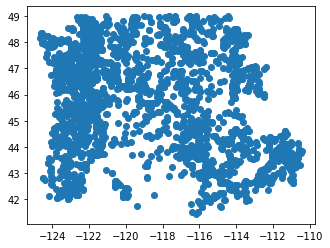

In [27]:
gdf.plot()